## Foundations of Data Mining: Assignment 2

Please complete all assignments in this notebook. You should submit this notebook, as well as a PDF version (See File > Download as).

In [2]:
# Please fill in your names here
NAME_STUDENT_1 = "Bram van der Pol"
NAME_STUDENT_2 = "Joris van der Heijden"

In [3]:
%matplotlib inline
from preamble import *
plt.rcParams['figure.dpi'] = 200 # This controls the size of your figures
# Comment out and restart notebook if you only want the last output of each cell.
InteractiveShell.ast_node_interactivity = "all" 
HTML('''<style>html, body{overflow: visible !important} .CodeMirror{min-width:105% !important;} .rise-enabled .CodeMirror, .rise-enabled .output_subarea{font-size:140%; line-height:1.2; overflow: visible;} .output_subarea pre{width:110%}</style>''') # For slides

## Support Vector Bananas (4 points (2+2))
We will first explore SVM kernels and hyperparameters on an artificial dataset representing multiple banana shapes. 

In [18]:
from sklearn.model_selection import *
bananas = oml.datasets.get_dataset(1460) # Download banana data
X, y = bananas.get_data(target=bananas.default_target_attribute);
#X_del, X, y_del, y = train_test_split(X, y, test_size=0.1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=1/4)

1 . Evaluate how well an SVM classifier can fit the data. 

- Use a linear, polynomial and radial basis function (RBF) kernel, using their default hyperparameters. Evaluate the performance of each kernel using the test set and AUC. Which one works best? 

All three kernels are implemented and the results are shown below. By visual inspection the polynomial kernel works best, this is confirmed by the scores

- Visualize the results using the visualization code also used in class (under mglearn/plot_svm.py > plot_svm_kernels). Also show the AUC score and the number of support vectors. Explain intuitively how well the data is fitted, why the kernel is (not) able to fit the data, whether it is under- or overfitting, etc.

The data is not linear neither based on a radial basis (for sine cosine based data). Therefore the hyperplane cannot be fitted and therefore many support vectors (3 times more than for the polynomial kernel) exist for these situations. All kernels are not overfitting, because the radii are relatively large and no islands appear in the contour plot. 

(3975, 2)
(5300,)


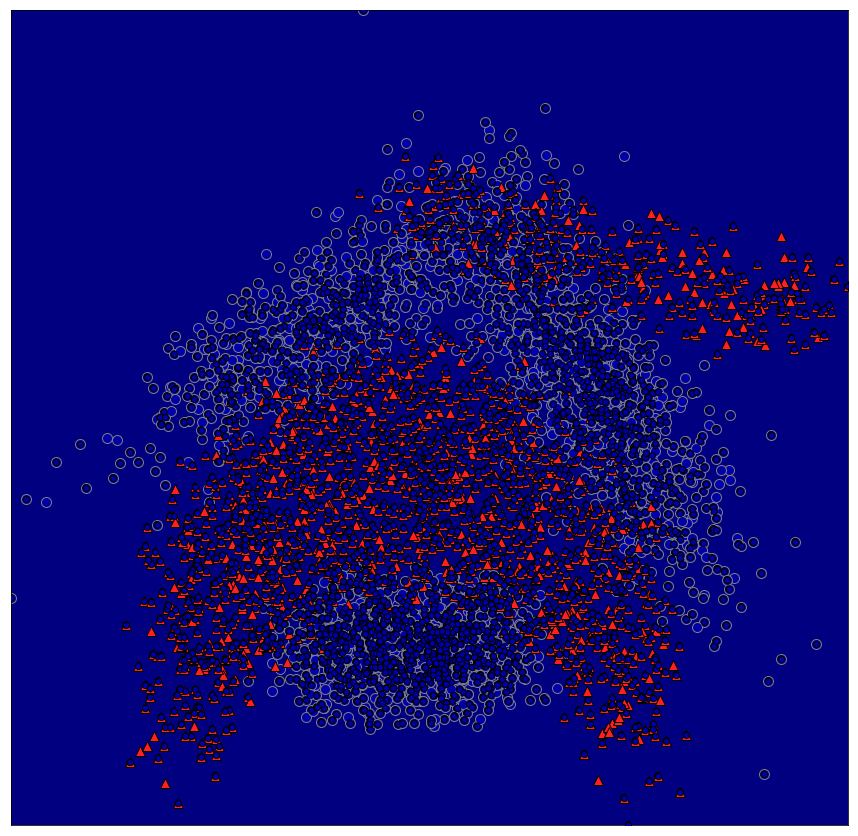

Support vectors:
(3613, 2)


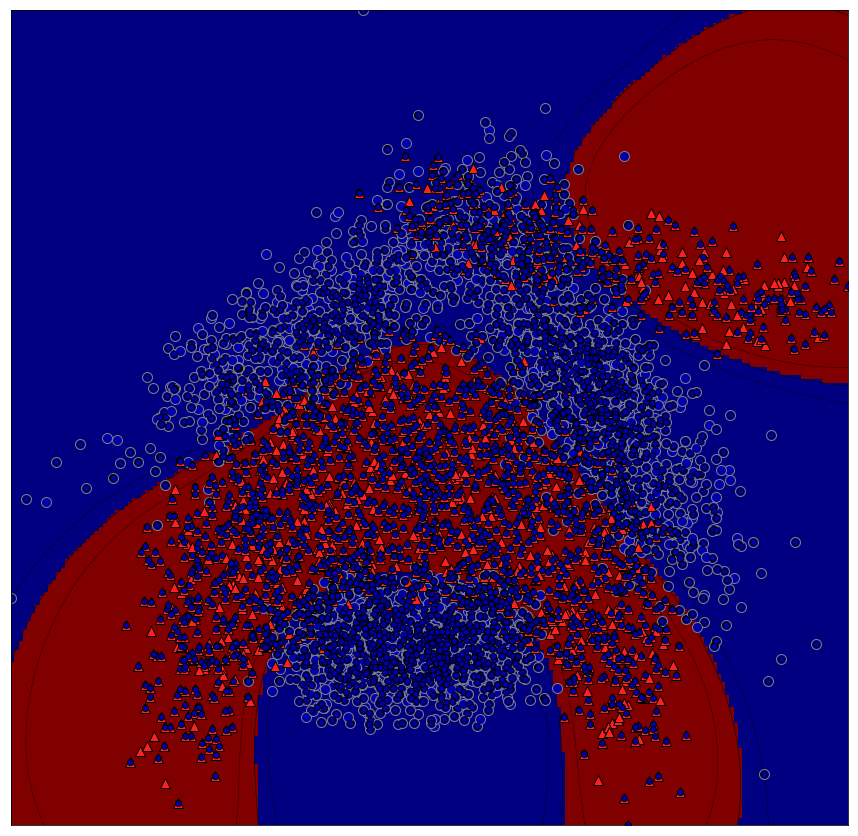

Support vectors:
(1180, 2)


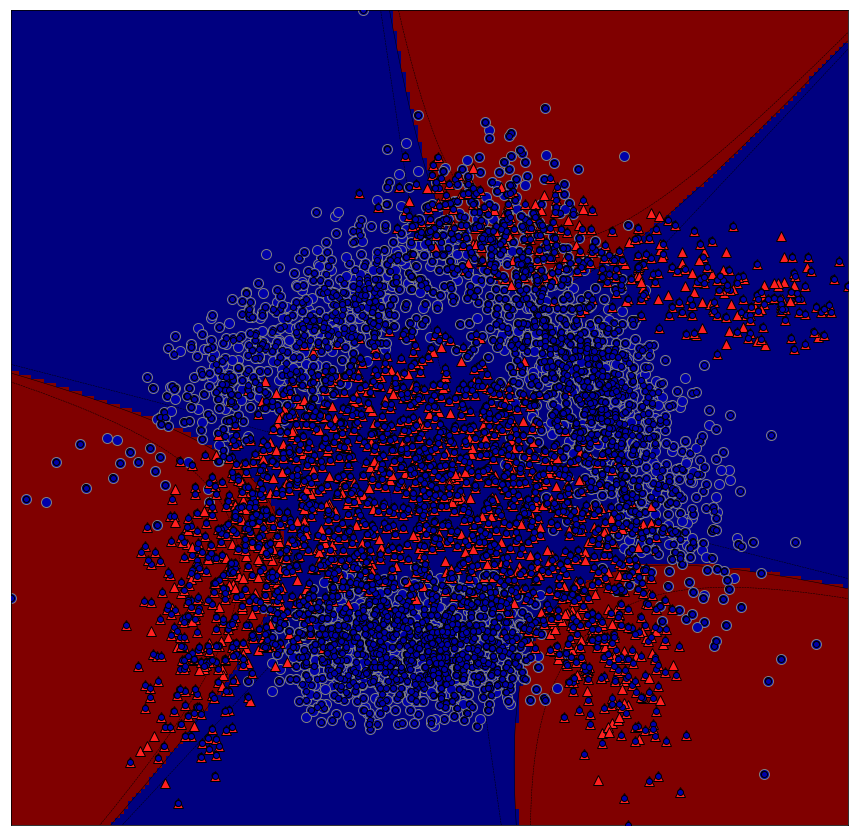

Support vectors:
(3218, 2)


In [5]:
from sklearn import svm
from sklearn.metrics import roc_curve, auc

#C = 1.0  # SVM regularization parameter
models = (svm.SVC(kernel='linear'),
          #svm.LinearSVC(),
          svm.SVC(kernel='rbf'),
          svm.SVC(kernel='poly', degree=3))
models = (clf.fit(X_train, y_train) for clf in models)

print(X_train.shape)
print(y.shape)


def Visualize():
    roc_auc = np.zeros((3,1))
    score = np.zeros((3,1))
    fignum=0
    # plot the line, the points, and the nearest vectors to the plane
    for clf in models:

        plt.figure(fignum, figsize=(15, 15))
        plt.clf()

        plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
                    facecolors='none', zorder=10, edgecolors='k')
        plt.scatter(X_train[:, 0], X_train[:, 1], zorder=10, cmap=plt.cm.Paired,
                   edgecolors='k')

        mglearn.discrete_scatter(X[:, 0], X[:, 1], y)

        plt.axis('tight')
        x_min = np.min(X_train[:,0])
        x_max = np.max(X_train[:,0])
        y_min = np.min(X_train[:,1])
        y_max = np.max(X_train[:,1])

        XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j] # Make a grid
        Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()]) # Calculate which color for the map using the clf 

        # Put the result into a color plot
        Z = Z.reshape(XX.shape)
        plt.figure(fignum, figsize=(4, 3))
        #plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
        plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.jet)
        plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
                    levels=[-.5, 0, .5])

        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)

        plt.xticks(())
        plt.yticks(())
        
        plt.show()
        
        y_score = clf.fit(X_train, y_train).decision_function(X_test)

        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc[fignum] = auc(fpr, tpr)
        
        score[fignum]=clf.score(X_test,y_test)
        
        print("Support vectors:")
        print(clf.support_vectors_[:].shape)

        if fignum==3:
            print('score= ',score)
            print('roc_auc= ',roc_auc)
        fignum = fignum + 1

Visualize()



2 . Pick the RBF kernel and optimize the two most important hyperparameters (the $C$ parameter and the kernel width $\gamma$). 

- First, optimize manually using 3 values for each (a very small, default, and very large value). For each of the 9 combinations, create the same RBF plot as before, report the number of support vectors, and the AUC performance. Explain the performance results. When are you over/underfitting?

The C hyperparameter is the penatly function for the errors, hyperparamter $\gamma$ is the kernel cooeficient. A large C parameter value leads to fewer support vectors. Therfore:
When the C paramters is small this increases bias, reduces variance, more underfitting.
When the C parameter is large this reduces bias, increases variance, more overfitting.
A small value for $\gamma$ (used in the kernel trick) results in a larger effect radius.
This results in very smooth decision boundaries for low $\gamma$ values.
A large $\gamma$ value leads to complex boundaries.
These effects are visible in the plots made below.

- Next, optimize the hyperparameters using a grid search and 10-fold cross validation. Show a heatmap of the results and report the optimal hyperparameter values.
    - Hint: values for C and $\gamma$ are typically in [$2^{-15}..2^{15}$] on a log scale. Use at least 10 values for each.
    
See Figure below. The best fit is made for: 

In [6]:
#C = 1.0  # SVM regularization parameter
models = (svm.SVC(kernel='rbf',C=2e-10,gamma=2e-10),svm.SVC(kernel='rbf',C=2e-10),
          svm.SVC(kernel='rbf',C=2e-10,gamma=2e10),
          svm.SVC(kernel='rbf',gamma=2e-10),svm.SVC(kernel='rbf'),
          svm.SVC(kernel='rbf',gamma=2e10),
          svm.SVC(kernel='rbf',C=2e10,gamma=2e-10),svm.SVC(kernel='rbf',C=2e10),
          svm.SVC(kernel='rbf',C=2e10,gamma=2e10),)
models = (clf.fit(X_train, y_train) for clf in models)

print(X_train.shape)
print(y.shape)


def Visualize():
    roc_auc = np.zeros((9,1))
    score = np.zeros((9,1))
    fignum=0
    # plot the line, the points, and the nearest vectors to the plane
    
    for clf in models:
        plt.figure(fignum, figsize=(15, 15))
        plt.clf()

        plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
                    facecolors='none', zorder=10, edgecolors='k')
        plt.scatter(X_train[:, 0], X_train[:, 1], zorder=10, cmap=plt.cm.Paired,
                   edgecolors='k')

        mglearn.discrete_scatter(X[:, 0], X[:, 1], y)

        plt.axis('tight')
        x_min = np.min(X_train[:,0])
        x_max = np.max(X_train[:,0])
        y_min = np.min(X_train[:,1])
        y_max = np.max(X_train[:,1])

        XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j] # Make a grid
        Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()]) # Calculate which color for the map using the clf 

        # Put the result into a color plot
        Z = Z.reshape(XX.shape)
        plt.figure(fignum, figsize=(4, 3))
        #plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
        plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.jet)
        plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
                    levels=[-.5, 0, .5])

        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)

        plt.xticks(())
        plt.yticks(())
        
        plt.show()
        
        y_score = clf.fit(X_train, y_train).decision_function(X_test)

        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc[fignum] = auc(fpr, tpr)
        
        score[fignum]=clf.score(X_test,y_test)
        
        print("Support vectors:")
        print(clf.support_vectors_[:].shape)

        if fignum==9:
            print('score= ',score)
            print('roc_auc= ',roc_auc)
        fignum = fignum + 1

#Visualize()


(3975, 2)
(5300,)


In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV 
import matplotlib

def Q2():
    CA=np.logspace(-15,15,5)
    gammaA=np.logspace(-15,15,5)
    p_grid = {"C": CA,
          "gamma": gammaA}
    clf=svm.SVC(kernel='rbf')
    grid = GridSearchCV(clf, param_grid=p_grid, cv=10, n_jobs=1)    
    grid.fit(X_train, y_train)

    results = pd.DataFrame(grid.cv_results_)

    print("Best params:\n{}\n".format(grid.best_params_))
    print("Best cross-validation score: {:.2f}".format(grid.best_score_))
    print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))


    scores = np.array(results.mean_test_score).reshape(len(CA),len(gammaA))

    # plot the mean cross-validation scores
    plt.figure(1, figsize=(15, 15))
    print(p_grid['gamma'])
    print(np.array(map(str,p_grid['gamma'])))
    str1=np.char.mod('%.3e',CA)
    str2=np.char.mod('%.3e',gammaA)
    mglearn.tools.heatmap(scores, ylabel='C', yticklabels=str1,
                      xlabel='gamma', xticklabels=str2, cmap="viridis",fmt="%.3f")
            #matplotlib.ticker.LogFormatterExponent(base=10.0, labelOnlyBase=False, minor_thresholds=None, linthresh=None));
    #plt.ticklabel_format(style='sci')
    ax = plt.gca
    #ax.XData = str(np.array(gammaA),fmt="%.3f")
    plt.title("ElasticNet score")
Q2()

## Building Kernels (4 points (0.5+0.5+1+2))

Consider the artificial dataset given below. It represents a sine wave with added noise.

1. Fit an SVM Regressor with the default RBF kernel, and plot the predictions on all data points in [0, 40]. 

    - Does it fit the data well? Does it extrapolate well (in the range [30,40])? Explain your findings. 
    - Can you get better results by tweaking the kernel or the other SVM parameters?
    
The linear, poly and sigmoid kernels all yielded poor fits. Furthermore, running a fit on the poly kernel took a long time to run, so the focus was shifted to optimizing other parameters
using the rbf kernel. After varying gamma, a value of 0.5 which is sleightly lower than the 1 default improved the fit in the [0,30] range. Other values for C did not improve the fit.
Adopting epsilon=0.01 lead to an almost perfect fit in the [0,20] range. None of the parameters improved the fit in the [30,40] range significantly.
    
2. Implement your own linear kernel. This is a function that takes 2 vectors (arrays) and returns the dot product:

      $$k(\mathbf{x}_i,\,\mathbf{x}_j) = \mathbf{x}_i \cdot \mathbf{x}_j$$
    - Build an SVM regressor using that kernel by passing your kernel function as the `kernel` hyperparameter. 
    - Fit it on the sine data and plot the predictions on all data points. Interpret the results.
    
3. Since this data is periodic, it makes sense to implement a periodic kernel instead. 

    - This is the Exponential Sine Squared kernel, with length scale $\Gamma$ and periodicity $P$:
  $$k(\mathbf{x}_i,\,\mathbf{x}_j) = \exp \left( -\Gamma\,\sin^2\left[\frac{\pi}{P}\,\left|\left|x_i-x_j\right|\right|\right]\right)$$
    - Implement it, using the defaults $\Gamma=1$, periodicity $P=1$, and Euclidean distance.
    - Train an SVM regressor with it, fit in on the same data and plot the result. Interpret the outcome. 
    - Think about what $\Gamma$ and $P$ represent. Can you improve the fit by manually adjusting them? Explain your findings.
    - Optimize $\Gamma$ and periodicity $P$ (using `true_y` as the ground truth). Use a grid search or random search, $\Gamma \in [0,1]$, $P \in [1,100]$, try at least 5 values for each.

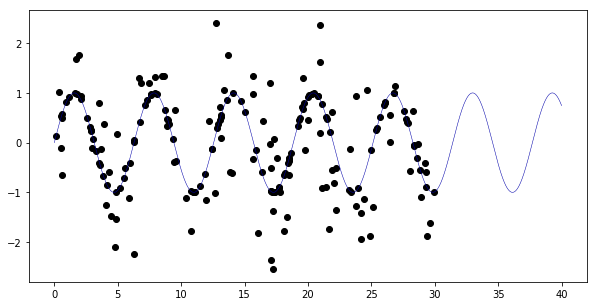

In [8]:
# Generate sample data
rng = np.random.RandomState(0) # Random seed, for reproducibility 
X = 30 * rng.rand(200, 1)
y = np.sin(X).ravel() 
y[::2] += rng.normal(scale = 1.0, size = X.shape[0] // 2) # adds noise

X_plot = np.linspace(0, 40, 10000)[:, None] # A larger range to evaluate on
true_y = np.sin(X_plot) # and the 'true' target function



plt.figure(figsize=(10, 5))
plt.scatter(X, y, c='k', label='Data')
plt.plot(X_plot, true_y);

NameError: name 'r2_score' is not defined

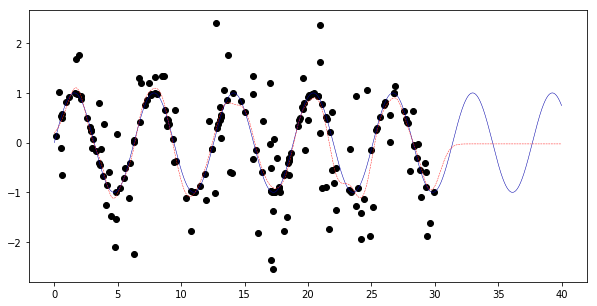

In [9]:
# assignment 2.1 - 2.3
from sklearn import svm
from sklearn.metrics import make_scorer, r2_score

def ass1_1():
    svr_rbf = svm.SVR()    
    svr_rbf.fit(X,y)
    y_rbf = svr_rbf.predict(X_plot)

    '''
    print("Support vectors:")
    print(svr_rbf.support_vectors_[:])
    print("Coefficients:")
    print(svr_rbf.dual_coef_[:])
    '''

    y_rbf = svr_rbf.predict(X_plot)
    plt.figure(figsize=(10, 5))
    plt.scatter(X, y, c='k', label='Data')
    plt.plot(X_plot, true_y);
    #plt.plot(X[:40], y_rbf[:40]) #take first 40 elements - array[start:stop:step]
    plt.plot(X_plot, y_rbf) 
    print('r2 score: ',r2_score(y_rbf.reshape(-1, 1) , true_y))
    return

ass1_1()

In [ ]:
# assignment 2.1 - 2.3
from sklearn import svm


def ass1_1():
    svr_rbf = svm.SVR()    
    svr_rbf.fit(X,y)
    y_rbf = svr_rbf.predict(X_plot)

    '''
    print("Support vectors:")
    print(svr_rbf.support_vectors_[:])
    print("Coefficients:")
    print(svr_rbf.dual_coef_[:])
    '''

    y_rbf = svr_rbf.predict(X_plot)
    plt.figure(figsize=(10, 5))
    plt.scatter(X, y, c='k', label='Data')
    plt.plot(X_plot, true_y);
    #plt.plot(X[:40], y_rbf[:40]) #take first 40 elements - array[start:stop:step]
    plt.plot(X_plot, y_rbf) 
    return

ass1_1()

In [ ]:
#assignment 1_1.2

from sklearn import svm


def ass1_1_2():
    C = 1.0  # SVM regularization parameter
    '''
    models = (svm.SVR(kernel='rbf', C=C, gamma=0.001 ),
                svm.SVR(kernel='rbf', C=C, gamma=0.01 ),
                svm.SVR(kernel='rbf', C=C, gamma=0.1 ),
                svm.SVR(kernel='rbf', C=C, gamma=0.5),
                svm.SVR(kernel='rbf', C=C, gamma=1),
                svm.SVR(kernel='rbf', C=C, gamma=10),
                svm.SVR(kernel='rbf', C=C, gamma=100),
                svm.SVR(kernel='rbf', C=C, gamma=1000),
             )
    '''
    models = (
                svm.SVR(kernel='rbf', C=C, gamma=0.5,epsilon=0.01, tol=1e-3),
             )
    
    models = (clf.fit(X, y) for clf in models)

    for clf in models:
        print("start iteration")

        y_rbf = clf.predict(X_plot)
        print(clf.support_vectors_[:].shape)
        
        plt.figure(figsize=(10, 5))
        plt.scatter(X, y, c='k', label='Data')
        plt.plot(X_plot, true_y);
        #plt.plot(X[:40], y_rbf[:40]) #take first 40 elements - array[start:stop:step]
        plt.plot(X_plot, y_rbf) 
        plt.show()
        print('r2 score: ',r2_score(y_rbf.reshape(-1, 1) , true_y))
    
    print("done!")
    return

ass1_1_2()


In [ ]:
#assignment 1_2

from sklearn import svm

def custom_kernel(X, Y):
    return np.dot(X, Y.T)

def ass1_2():
    models = (
                svm.SVR(kernel=custom_kernel),
             )
    
    models = (clf.fit(X, y) for clf in models)

    for clf in models:
        print("start iteration")

        y_rbf = clf.predict(X_plot)
        print(clf.support_vectors_[:].shape)
        
        plt.figure(figsize=(10, 5))
        plt.scatter(X, y, c='k', label='Data')
        plt.plot(X_plot, true_y);
        #plt.plot(X[:40], y_rbf[:40]) #take first 40 elements - array[start:stop:step]
        plt.plot(X_plot, y_rbf) 
        plt.show()
        '''
        print("Support vectors:")
        print(clf.support_vectors_[:])
        print("Coefficients:")
        print(clf.dual_coef_[:])
        '''
        print('r2 score: ',r2_score(y_rbf.reshape(-1, 1) , true_y))
    
    print("done!")
    return

ass1_2()

In [ ]:
#assignment 1_3

from sklearn import svm

def build_custom_kernel(gamma,P):
    def custom_kernel(X, Y):
        abs = np.absolute(X-Y.T)    
        temp1 = (np.pi/P) * abs;    
        temp2 = np.power(np.sin(temp1),2);    
        result = np.exp(-gamma*temp2);    
    
        return result
    return custom_kernel

def ass1_2():
    models = (
                svm.SVR(kernel=build_custom_kernel(1,1)),
                svm.SVR(kernel=build_custom_kernel(1,np.pi*2)),
             )
    
    models = (clf.fit(X, y) for clf in models)

    for clf in models:
        print("start iteration")

        y_rbf = clf.predict(X_plot)
        print(clf.support_vectors_[:].shape)
        
        plt.figure(figsize=(10, 5))
        plt.scatter(X, y, c='k', label='Data')
        plt.plot(X_plot, true_y);
        #plt.plot(X[:40], y_rbf[:40]) #take first 40 elements - array[start:stop:step]
        plt.plot(X_plot, y_rbf) 
        plt.show()
        '''
        print("Support vectors:")
        print(clf.support_vectors_[:])
        print("Coefficients:")
        print(clf.dual_coef_[:])
        '''
    
        print('r2 score: ',r2_score(y_rbf.reshape(-1, 1) , true_y))
        
    print("done!")
    return

ass1_2()

In [ ]:
#assignment 1_3.grid
from sklearn import svm
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.metrics import make_scorer, r2_score

import inspect
import math




def build_custom_kernel(gamma,P):
    
    def custom_kernel(X, Y):
        abs = np.absolute(X-Y.T)    
        temp1 = (np.pi/P) * abs;    
        temp2 = np.power(np.sin(temp1),2);    
        result = np.exp(-gamma*temp2);    
        #print("P: {},gamma: {},".format(P,gamma))
        return result
    return custom_kernel


def my_scorer(estimator, y_true, y_predicted):
    global best_score
    
    y_pred = estimator.predict(X_plot) #predict on all X_plot values to be able to compare to true_y
    score = r2_score(true_y, y_pred)
        
    return score

def grid_1_3(regression, gridy, gridx, yticks, xticks, param_grid):    
    
    grid = GridSearchCV(regression, param_grid=param_grid, cv=2, n_jobs=1, scoring=my_scorer )    
    #print(regression.get_params().keys())    
    grid.fit(X, y)
    

    print("Best params:\n{}\n".format(grid.best_params_))
    print("Best score: {:.5f}".format(grid.best_score_))
    

    #print("Best score: {:.5f}".format(best_score))
   # print("Test-set score: {:.2f}".format(grid.score(y.reshape(-1, 1), true_y)))
    
    # convert to Dataframe
    results = pd.DataFrame(grid.cv_results_)

    scores = np.array(results.mean_test_score).reshape(gridy, gridx)
    
    # plot the mean cross-validation scores
    mglearn.tools.heatmap(scores, xlabel='gamma', xticklabels=xticks,
                      ylabel='P', yticklabels=yticks, cmap="viridis", fmt="%.5f");
    #plt.title("ElasticNet score")
    #plt.plot(10,10)
    #plt.figure(figsize=(1,1))
    plt.title('r2 score')
    plt.rcParams["figure.figsize"] = (20,5)
    plt.show() 
    return

#used to determine which axis is P, and which axis is gamma in plotted heatmap
def check_axis():
    grid_1_3(svm.SVR(), 3, 5, [1,1,1], [0.1,0.3,0.5,0.7,0.9], 
             {'kernel': [build_custom_kernel(0.1, 1), build_custom_kernel(0.3, 1), build_custom_kernel(0.5, 1), build_custom_kernel(0.7, 1), build_custom_kernel(0.9, 1), 
                        build_custom_kernel(0.1, 1), build_custom_kernel(0.3, 1), build_custom_kernel(0.5, 1), build_custom_kernel(0.7, 1), build_custom_kernel(0.9, 1), 
                        build_custom_kernel(0.1, 1), build_custom_kernel(0.3, 1), build_custom_kernel(0.5, 1), build_custom_kernel(0.7, 1), build_custom_kernel(0.9, 1),                     
    ]})
    return  
     
#optimize gamma and P for a wide range of values. takes about 2 minutes to run
def optimize_p_gamma():        

    grid_1_3(svm.SVR(), 11, 5, [1,4,5,6,'2pi',7,10,30,50,70,90], [0.1,0.3,0.5,0.7,0.9], 
             {'kernel': [build_custom_kernel(0.1, 1), build_custom_kernel(0.3, 1), build_custom_kernel(0.5, 1), build_custom_kernel(0.7, 1), build_custom_kernel(0.9, 1), 
                        build_custom_kernel(0.1, 4), build_custom_kernel(0.3, 4), build_custom_kernel(0.5, 4), build_custom_kernel(0.7, 4), build_custom_kernel(0.9, 4), 
                        build_custom_kernel(0.1, 5), build_custom_kernel(0.3, 5), build_custom_kernel(0.5, 5), build_custom_kernel(0.7, 5), build_custom_kernel(0.9, 5), 
                        build_custom_kernel(0.1, 6), build_custom_kernel(0.3, 6), build_custom_kernel(0.5, 6), build_custom_kernel(0.7, 6), build_custom_kernel(0.9, 6), 
                        build_custom_kernel(0.1, np.pi*2), build_custom_kernel(0.3, np.pi*2), build_custom_kernel(0.5, np.pi*2), 
                        build_custom_kernel(0.7, np.pi*2), build_custom_kernel(0.9, np.pi*2),
                        build_custom_kernel(0.1, 7), build_custom_kernel(0.3, 7), build_custom_kernel(0.5, 7), build_custom_kernel(0.7, 7), build_custom_kernel(0.9, 7),                                 
                        build_custom_kernel(0.1, 10), build_custom_kernel(0.3, 10), build_custom_kernel(0.5, 10), build_custom_kernel(0.7, 10), build_custom_kernel(0.9, 10), 
                        build_custom_kernel(0.1, 30), build_custom_kernel(0.3, 30), build_custom_kernel(0.5, 30), build_custom_kernel(0.7, 30), build_custom_kernel(0.9, 30), 
                        build_custom_kernel(0.1, 50), build_custom_kernel(0.3, 50), build_custom_kernel(0.5, 50), build_custom_kernel(0.7, 50), build_custom_kernel(0.9, 50), 
                        build_custom_kernel(0.1, 70), build_custom_kernel(0.3, 70), build_custom_kernel(0.5, 70), build_custom_kernel(0.7, 70), build_custom_kernel(0.9, 70),
                        build_custom_kernel(0.1, 90), build_custom_kernel(0.3, 90), build_custom_kernel(0.5, 90), build_custom_kernel(0.7, 90), build_custom_kernel(0.9, 90)
]}) 
    return
#optimize gamma with P=2pi                          
def optimize_gamma():
    
    grid_1_3(svm.SVR(), 1, 21, ['2pi'], [0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1], 
        {'kernel': [build_custom_kernel(0, np.pi*2), build_custom_kernel(0.05, np.pi*2), build_custom_kernel(0.1, np.pi*2),build_custom_kernel(0.15, np.pi*2), 
                    build_custom_kernel(0.2, np.pi*2), build_custom_kernel(0.25, np.pi*2), build_custom_kernel(0.3, np.pi*2),build_custom_kernel(0.35, np.pi*2), 
                    build_custom_kernel(0.4, np.pi*2), build_custom_kernel(0.45, np.pi*2), build_custom_kernel(0.5, np.pi*2),build_custom_kernel(0.55, np.pi*2), 
                    build_custom_kernel(0.6, np.pi*2), build_custom_kernel(0.65, np.pi*2), build_custom_kernel(0.7, np.pi*2),build_custom_kernel(0.75, np.pi*2), 
                    build_custom_kernel(0.8, np.pi*2), build_custom_kernel(0.85, np.pi*2), build_custom_kernel(0.9, np.pi*2),build_custom_kernel(0.95, np.pi*2), 
                    build_custom_kernel(1, np.pi*2)
    ]}) 
    return

check_axis() # runtime: a few seconds
#optimize_p_gamma() # runtime: 2 minutes

#optimize_gamma() # runtime: 30 secondes


4 . We now make the problem a bit more challenging by adding an upward trend:

- Fit the same SVM using the optimal parameters from the previous subtask and plot the results. Do they still work? Explain what you see.
- Fit a Gaussian process (GP) using the kernels given below. First use the singular ExpSineSquared kernel (the implementation provided by sklearn this time), then build a new kernel consisting of the 3 components given below. Use both to predict all points for the "rising noisy sine" data and plot the results as usual. Interpret the results.
    - For the GP, it may help to use `normalize_y=True` since the y-values are not around 0. Setting `alpha=0.1` may help with possible numerical issues, otherwise keep it at 0.
- Also plot the _uncertainty interval_ around the predictions. You can ask the GP to return the standard deviation during prediction with the `return_std=True` hyperparameter. Plot a band 2 standard deviations above and below the prediction. You can use MatPlotLib's `fill_between` as shown in class.
    - You can combine the 3 models in one plot for easy comparison.
- We've provided reasonable values for the kernel hyperparameters above. Can you optimize them further to get an even better fit? Think about what the hyperparameters do and optimize the ones you think are most worth tuning.

In [ ]:
# Generate sample data with added trend
rng = np.random.RandomState(0)
X = 30 * rng.rand(200, 1)
y = X.ravel()/2 + np.sin(X).ravel()
y[::2] += rng.normal(scale = 1.0, size = X.shape[0] // 2)  # add noise

X_plot = np.linspace(0, 40, 10000)[:, None]
true_y = X_plot/2 + np.sin(X_plot)

plt.figure(figsize=(10, 5))
plt.scatter(X, y, c='k', label='Data')
plt.plot(X_plot, true_y);

In [ ]:
#assignment 1_4

from sklearn import svm

def build_custom_kernel(gamma,P):
    def custom_kernel(X, Y):
        abs = np.absolute(X-Y.T)    
        temp1 = (np.pi/P) * abs;    
        temp2 = np.power(np.sin(temp1),2);    
        result = np.exp(-gamma*temp2);    
    
        return result
    return custom_kernel

def ass1_4():
    models = (svm.SVR(kernel=build_custom_kernel(0.2,np.pi*2)),
             )
    
    models = (clf.fit(X, y) for clf in models)

    for clf in models:
        print("start iteration")

        y_rbf = clf.predict(X_plot)
        print(clf.support_vectors_[:].shape)
        
        plt.figure(figsize=(10, 5))
        plt.scatter(X, y, c='k', label='Data')
        plt.plot(X_plot, true_y);
        #plt.plot(X[:40], y_rbf[:40]) #take first 40 elements - array[start:stop:step]
        plt.plot(X_plot, y_rbf) 
        plt.show()
        '''
        print("Support vectors:")
        print(clf.support_vectors_[:])
        print("Coefficients:")
        print(clf.dual_coef_[:])
        '''
    
        print('r2 score: ',r2_score(y_rbf.reshape(-1, 1) , true_y))
        
    print("done!")
    return

ass1_4()

In [ ]:
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, RBF

# Replace `length_scale` and `periodicity` with the values found in the previous part.
kernel_simple = ExpSineSquared(length_scale=1, periodicity=1) # periodic component

k1 = 4300 * RBF(length_scale=70.0)  # long term smooth rising trend
k2 = 6 * RBF(length_scale=90.0) * ExpSineSquared(length_scale=1.3, periodicity=1.0)  # periodic component
k3 = 0.03 * RBF(length_scale=0.134) + WhiteKernel(noise_level=0.035)  # noise terms

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import r2_score

def Q1_4():
   
    plt.figure(figsize=(20, 20))

    printPlot(GaussianProcessRegressor(kernel=kernel_simple,normalize_y=True,alpha=0.1), "simple kernel")
    printPlot(GaussianProcessRegressor(kernel=k1,normalize_y=True,alpha=0.1), "k1")
    printPlot(GaussianProcessRegressor(kernel=k2,normalize_y=True,alpha=0.1), "k2")
    printPlot(GaussianProcessRegressor(kernel=k3,normalize_y=True,alpha=0.1), "k3")
    
    return

def Q1_4_2():
   
    plt.figure(figsize=(20, 20))
    printPlot(GaussianProcessRegressor(kernel=kernel_simple2,normalize_y=True,alpha=0.1), "k1_1")
    printPlot(GaussianProcessRegressor(kernel=kernel_simple_k1,normalize_y=True,alpha=0.1), "k1+simple kernel, periodicity 2pi")
    
    return

def printPlot(clf, title):
    clf.fit(X, y)
    y_rbf,sigma = clf.predict(X_plot,return_std=True)
        
    plt.figure(figsize=(10, 5))
    plt.scatter(X, y, c='k', label='Data')
    plt.plot(X_plot, true_y);
    #plt.plot(X[:40], y_rbf[:40]) #take first 40 elements - array[start:stop:step]
    plt.fill(np.concatenate([X_plot, X_plot[::-1]]),
    np.concatenate([y_rbf - sigma,
            (y_rbf + sigma)[::-1]]),
    alpha=.5, fc='b', ec='None')
    plt.plot(X_plot, y_rbf) 
    plt.title(title)
    plt.show()
    #print(clf.score(y_rbf.reshape(-1, 1) , true_y))
    print('r2 score: ',r2_score(y_rbf.reshape(-1, 1) , true_y))
    
Q1_4()

Q1_4_2()

## Bayesian updates (3 points (2+1))

We consider real data about solar radiation measured by a weather balloon:
https://www.openml.org/d/512. We'll use only the raw data (at least the first 1000 points) and try to learn the (very noisy) trend. 

1. Train a Gaussian process on an increasing amount of samples of the training data. Use a simple RBF kernel:
`RBF(10, (1e-2, 1e2))`

 - Start with 10 _random_ samples and plot the predictions (both the mean and the uncertainty interval) for both training and test data, as shown in class. Also compute $R^2$ on the training data.
 - Repeat and 10 more points, retrain and redraw. Do this a couple of times and interpret/explain what you see. 
 
We printed the r2 score for both the train and prediction. The r2 score based on only the train data goes up as the number of samples increases. This is logical because a model can be better fitted if more data is available. No overfitting is visible. 
 
2. Train the Gaussian on the full training set.

 - Plot the predictions (including the uncertainty interval) on the full dataset. Evaluate on the test set using $R^2$ 
 - Interpret the results. Is the kernel right? Is the GP under/overfitting?
 - Try to improve the results by tuning the kernel. Do this either manually or using a small grid/random search.

(1000, 1)
(500, 1)
(999, 1)
(999, 1)
(500, 1)
(500, 1)
(1500, 1)


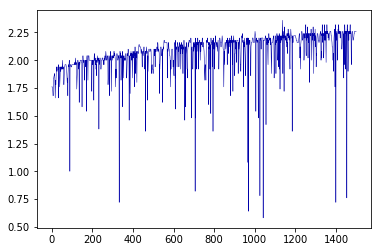

In [10]:
# Get the data
balloon_data = oml.datasets.get_dataset(512) # Download Balloon data
X, y = balloon_data.get_data(target=balloon_data.default_target_attribute);

train = X[:1000]                                         # (1000, 1)
test = X[1000:1500]                                      # (1000, 1)
X_train = np.array(list(range(1000)))[np.newaxis].T      # (1000, 1)
y_train = X[:1000].reshape(-1, 1)                        # (1000, 1)
X_test = np.array(list(range(1000,1500)))[np.newaxis].T  # (250, 1)
y_test = X[1000:1500].reshape(-1, 1)                     # (500, 1)
X_all = np.array(list(range(1500)))[np.newaxis].T        # (1500, 1)

pd.Series(X[:1500,0]).plot()

X_del, X_train, y_del, y_train = train_test_split(X_train, y_train, test_size=999)

print(train.shape)
print(test.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_all.shape)

#print(X_train[:,0])



r2 score predict=  -0.08369197409396634
r2 score train  0.16200130532352774


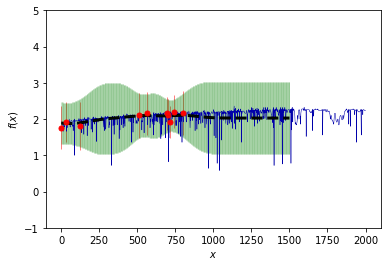

r2 score predict=  -0.07448849499770116
r2 score train  0.18224515509919814


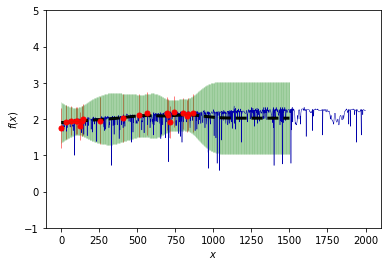

r2 score predict=  -0.04188003371156168
r2 score train  0.17043866511394024


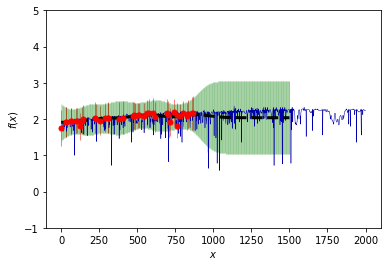

r2 score predict=  -0.019496042601673036
r2 score train  0.18910980872869287


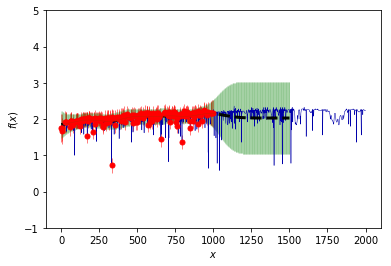

r2 score predict=  0.001664007233360243
r2 score train  0.21435494364245544


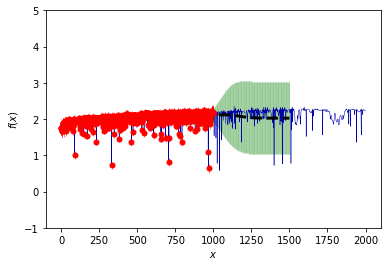

In [11]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import r2_score

def Q3_bram(testSize):
    X_del, X_train2, y_del, y_train2 = train_test_split(X_train, y_train, test_size=testSize, random_state=1337)
    plt.figure(figsize=(20, 20))
    
    #def f(x): #"""The function to predict."""
    #    return x
    
    X2 = X_train2
    # Observations
    y2 = y_train2
    dy = 0.5 + 1.0 * np.random.random(y2.shape)

    x = np.atleast_2d(np.linspace(0, 1500, 1000)).T

    #x = np.append(X2)
    ## Noisy example
    # Instanciate a Gaussian Process model
    #y = f(X).ravel()
    #dy = 0.5 + 1.0 * np.random.random(y.shape)
    
    kernel = RBF(10, (1e-2, 1e2)) #RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \ 
    gp = GaussianProcessRegressor(kernel=kernel,    n_restarts_optimizer=10,normalize_y=True,alpha=1e-0)
    # Fit to data using Maximum Likelihood Estimation of the parameters
    gp.fit(X2, y2)
    
    # Make the prediction on the meshed x-axis (ask for MSE as well)
    y_pred, sigma = gp.predict(x, return_std=True)
    y_pred2, sigma2 = gp.predict(X2, return_std=True)
    y_pred3, sigma3 = gp.predict(X_test[1:100,:], return_std=True)
    y_pred4, sigma4 = gp.predict(X_train, return_std=True)
    # Plot the function, the prediction and the 95% confidence interval based on
    # the MSE
    fig = plt.figure()
    #plt.plot(x, f(x), 'r:', label=u'$f(x) = x\,\sin(x)$')
    plt.plot(X)
    plt.errorbar(X2.ravel(), y2, sigma2, fmt='r.', markersize=10, label=u'Observations')
    plt.plot(x, y_pred, 'k', label=u'Prediction',linewidth=3)
    
    plt.errorbar(x.ravel(), y_pred, sigma, fmt='g', markersize=10, label=u'Observations',alpha=.2)
    #print(sigma)
    
    #should plot confidence interval but somehow does not work as expected
    #plt.fill(x,
    #np.concatenate([y_pred - 1.0100 * sigma,
    #(y_pred + 1.0100 * sigma)[::-1]]),
    #alpha=.2, fc='g', ec='None', label='95% confidence interval')
    
    print('r2 score predict= ',r2_score(y_test[1:100,:],y_pred3))
    print('r2 score train ',r2_score(y_train,y_pred4))
    plt.xlabel('$x$')
    plt.ylabel('$f(x)$')
    plt.ylim(-1, 5)
    #plt.xlim(200, 250) #limit plotted x range so that we can see more than solid blobs
    #plt.legend(loc='upper left')

    plt.show()
    
    
Q3_bram(10)

Q3_bram(20)

Q3_bram(40)

Q3_bram(200)

Q3_bram(998)


## A data mining challenge (4 points)

The goal here is to use everything you have learned to build the best model for a given classification task. We will use two tasks hosted on OpenML, so you will all receive the same cross-validation splits, and your model will be evaluated on the server. The goal is to reasonably select algorithms and hyperparameter settings to obtain the best model. You can also do model selection, pipeline building, and parameter optimization as you have done before. Skeleton code is provided in the OpenML tutorial. You need to optimize the AUROC score (calculated using 10-fold cross0-validation).

- Challenge 1: Detects accents in speech data.

    - The OpenML Task ID is 167132: https://www.openml.org/t/167132
    - The dataset description can be found here: https://www.openml.org/d/40910
    - Leaderboard: https://www.openml.org/t/167132#!people
    
- Challenge 2: Image recognition (CIFAR-10 subsample).

    - The OpenML Task ID is 167133: https://www.openml.org/t/167133
    - The dataset description can be found here: https://www.openml.org/d/40926
    - Leaderboard: https://www.openml.org/t/167133#!people
    - Note that this is a high-dimensional dataset (and not so small). Think carefully about how to run experiments in the  time available.
    
- You are able to see the solutions of others (by clicking in the timeline or run list), so you can learn from prior experiments (what seems to work, how long does it take to train certain models, ...). Resubmission of the exact same solution is not possible.
- You can share one account (one API key) per team. In case you use two, we take the one that performs best.
- Document the different experiments that you ran in this notebook (running them can of course be done outside of the notebook). For each experiment, provide a description of how and why you chose the algorithms and parameters that you submitted. Reason about which experiments to try, don't just do an immense random search.
- Points are rewarded as follows (independently for each task):

    - 1 point for the breadth of experiments you ran (algorithms, pipelines, hyperparameter settings)
    - 1 point for reasoning/insight and interpretation of the results
    - 1 (bonus) point for every team who has uploaded the best solution thus far **on AUC** (who reaches the top of the leaderboard at any moment during the assignment)
        - Exception: simply repeating top models with nearly identical hyperparameters. This will be checked on the timeline.
        - Note: On the leaderboard page, the 'frontier' line is drawn, and your top ranking is also shown in the leaderboard.
        
Note: Report the AUC scores of your best models in your report as well. In case of issues with OpenML we will use the experiments and scores mentioned your report.

In [12]:
#bananas = oml.datasets.get_dataset(1460) # Download banana data
Speech_data = oml.datasets.get_dataset(40926) # Download Speech_data
X, y = Speech_data.get_data(target=Speech_data.default_target_attribute);

#print(Speech_data)
X_split, X_del, y_split, y_del = train_test_split(X, y, test_size=1)
X_train, X_test, y_train, y_test = train_test_split(X_split, y_split, test_size=0.25)

#X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=.75)
print(X.shape)
print(y.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(20000, 3072)
(20000,)
(14999, 3072)
(14999,)
(5000, 3072)
(5000,)


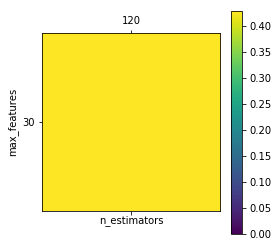

**Results for RandomForest**
Best cross-validation accuracy: 0.43
Test set score: 0.43
Best parameters: {'Forest__max_features': 30, 'Forest__n_estimators': 120}
Best estimator:
Pipeline(memory=None,
     steps=[('Forest', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=30, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=120, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])
clf step:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=30, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=120, n_jobs=1,
            oob_s

In [17]:
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix  
import time
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn import pipeline
from sklearn.svm import SVC  
    
def WhichAlgorithm():     
    Fraction=np.array([0.95])
    A = np.zeros((len(Fraction), 2)) # Accuracy Matrix
    T = np.zeros((len(Fraction),2))  # Computation time Matrix

    # Split the data in test data and train data (stratified 10% subsample)
    from sklearn.model_selection import train_test_split  
    
    #n1 = randint(0,len(y_test1))
    #n2 = randint(0,len(y_test1))

    for i in range(len(Fraction)):
        
        X_del, X_split, y_del, y_split = train_test_split(X, y, test_size=Fraction[i])
        X_train, X_test, y_train, y_test = train_test_split(X_split, y_split, test_size=0.25)
        
        print(i)
        
        # Solve the learning problems if the solutions do not exist yet
        #if not 'classifier' in locals(): 
        tic = time.clock()
        knn = KNeighborsClassifier(n_neighbors=5)  
        knn.fit(X_train, y_train) 
        toc = time.clock()
        #y_predKNearest = knn.predict(X_test)  
        Accuracy_KNearest=knn.score(X_test,y_test)
        A[i][0]=Accuracy_KNearest
        T[i][0]=toc-tic
        
        #if not 'Forest' in locals():   
        tic = time.clock()
        Forest = RandomForestClassifier()
        Forest.fit(X_train,y_train)
        toc = time.clock()
        #y_predForest = Forest.predict(X_test)  
        Accuracy_Forest=Forest.score(X_test,y_test) #accuracy_score(y_test,y_predForest)
        A[i][1]=Accuracy_Forest
        T[i][1]=toc-tic
        
    xas=Fraction
    plot1=plt.subplot(1,2,1);
    plt.plot(xas,A[:,0],linewidth=2);
    plt.plot(xas,A[:,1],linewidth=2);
    plt.title('Accuracy',fontweight='bold',fontsize=15);
    plt.xlabel('Fraction');
    plt.ylabel('Accuracy [%]');
#     plot1.set_ylim([0, 1])
    
#     red_patch = mpatches.Patch(color='red', label='The red data')
    plt.legend(['k-Nearest','RandomForest'])
    #plt.grid()
    plt.subplot(1,2,2);
    plt.plot(xas,T[:,0],linewidth=2);
    plt.plot(xas,T[:,1],linewidth=2);
    plt.title('Time',fontweight='bold',fontsize=15);
    plt.xlabel('Fraction');
    plt.ylabel('Time (s)');
    plt.grid()
    plt.legend(['k-Nearest','RandomForest'])
    plt.show()
    return
   
    length_data=len(y); #92000
    
    number_of_test=100; # To have more control of the computation time
    number_of_training=1000; # Not used

    Fractionb=np.array([0.02, 0.05])
    
    A1 = np.zeros((len(Fractionb),1)) # Accuracy Matrix
    T1 = np.zeros((len(Fractionb),1))  # Computation time Matrix

    # Split the data in test data and train data (stratified 10% subsample)
    from sklearn.model_selection import train_test_split  

    #n1 = randint(0,len(y_test1))
    #n2 = randint(0,len(y_test1))

    for i in range(len(Fractionb)):
        X_del, X_split, y_del, y_split = train_test_split(X, y, test_size=Fractionb[i])
        X_train, X_test, y_train, y_test = train_test_split(X_split, y_split, test_size=0.25)

        print(i)
        
        #if not 'logistic' in locals(): 
        tic = time.clock()
        logistic = LogisticRegression()
        logistic.fit(X_train,y_train)
        toc = time.clock()
#         y_predLogistic = logistic.predict(X_test) 
        Accuracy_Logistic=logistic.score(X_test,y_test) #accuracy_score(y_test,y_predLogistic)
        A1[i][0]=Accuracy_Logistic
        T1[i][0]=toc-tic       
        
    xas=Fractionb
    plt.figure()
    plot1=plt.subplot(1,2,1);
    plt.plot(xas,A1[:,0],linewidth=2);
    plt.title('Accuracy',fontweight='bold',fontsize=15);
    plt.xlabel('Fraction');
    plt.ylabel('Accuracy [%]');
    plot1.set_ylim([0, 1])
    
#   red_patch = mpatches.Patch(color='red', label='The red data')
    plt.legend(['Logistic Regression'])
    #plt.grid()
    plt.subplot(1,2,2);
    plt.plot(xas,T1[:,0],linewidth=2);
    plt.title('Time',fontweight='bold',fontsize=15);
    plt.xlabel('Fraction');
    plt.ylabel('Time (s)');
    plt.grid()
    plt.legend(['Logistic Regression'])
    plt.tight_layout() 
    plt.show()

    return

def Scaling():
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_test=X_test_scaled
    X_train=X_train_scaled
# Do not use this in a grid search of cross validation, 
# because the scaler is based on the data that will be used in cross validation. Therefore build a pipeline

def ForestPipeLine(): # For a RandomForest
   
    
    param_grid={"Forest__n_estimators": [40 ,100],
            'Forest__max_features': [10, 100]}
        
    pipe = pipeline.Pipeline([("scaler", MinMaxScaler()), ("Forest", RandomForestClassifier())])
    
    grid = GridSearchCV(pipe, param_grid=param_grid, cv=10, n_jobs=8)
    grid.fit(X_train, y_train)
    print('**Results for RandomForest**')
    print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
    print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
    print("Best parameters: {}".format(grid.best_params_))
    print("Best estimator:\n{}".format(grid.best_estimator_)) #Show the best pipeline 
    # Get the SVM
    print("clf step:\n{}".format(
          grid.best_estimator_.named_steps["Forest"]))
    
def Pipeline2(): #Memory error
    from sklearn import pipeline
    from sklearn.preprocessing import PolynomialFeatures    
    
    param_grid = {'polynomialfeatures__degree': [1, 2, 3],
              'ridge__alpha': [0.001, 100]} #0.001, 0.01, 0.1, 1, 10, 100
    
    pipe = pipeline.make_pipeline(
    StandardScaler(),
    PolynomialFeatures(),
    Ridge())
        
    pipe = pipeline.make_pipeline( StandardScaler(), PolynomialFeatures(), Ridge())
    
    grid = GridSearchCV(pipe, param_grid=param_grid, cv=10)
    grid.fit(X_train, y_train)
    print('**Results for RandomForest**')
    print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
    print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
    print("Best parameters: {}".format(grid.best_params_))
    print("Best estimator:\n{}".format(grid.best_estimator_)) #Show the best pipeline 
    # Get the SVM
    #print("clf step:\n{}".format(
    #      grid.best_estimator_.named_steps["Forest"]))
    
    plt.matshow(grid.cv_results_['mean_test_score'].reshape(3, -1),
            vmin=0, cmap="viridis")
    plt.xlabel("ridge__alpha")
    plt.ylabel("polynomialfeatures__degree")
    plt.xticks(range(len(param_grid['ridge__alpha'])), param_grid['ridge__alpha'])
    plt.yticks(range(len(param_grid['polynomialfeatures__degree'])),
           param_grid['polynomialfeatures__degree'])

    plt.colorbar();

def TotalPipeline():
    '''
    param_grid = [
    {'classifier': [SVC()], 'preprocessing': [StandardScaler()],
     'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
     'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]}]

    pipe = pipeline.Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])
    grid = GridSearchCV(pipe, param_grid=param_grid, cv=10)
    grid.fit(X_train, y_train)
    
    plt.matshow(grid.cv_results_['mean_test_score'].reshape(3, -1),
            vmin=0, cmap="viridis")
    plt.xlabel("classifier__gamma")
    plt.ylabel("classifier__C")
    #plt.xticks(range(len(param_grid['classifier__gamma'])))
    #plt.yticks(range(len(param_grid['classifier__C'])))
    #plt.yticks(range(len(param_grid['polynomialfeatures__degree'])),
      #     param_grid['polynomialfeatures__degree'])

    plt.colorbar();
    '''
    #param_grid = [{'classifier': [RandomForestClassifier()],
    #           'preprocessing': [StandardScaler(), None], 'classifier__n_estimators': [1,2],
    #                                                       'classifier__max_features':[1,2]}]
    #pipe = pipeline.Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])

    #param_grid = {'Forest__n_estimators': np.linspace(1,300,1,dtype = int),
    #              'Forest__max_features':np.linspace(1,300,1,dtype = int)} #                  'max_depth':[10 20 30 40 50]
    param_grid = {'Forest__n_estimators': [120],
                  'Forest__max_features':[30]} 
    pipe = pipeline.Pipeline([("Forest", RandomForestClassifier())]) #("scaler", StandardScaler()), 
    
    
    plt.figure(figsize=(15, 15))
    grid = GridSearchCV(pipe, param_grid=param_grid, cv=10, n_jobs=8)
    
    grid.fit(X_train, y_train)
    plt.matshow(grid.cv_results_['mean_test_score'].reshape(len(param_grid['Forest__max_features']), -1),
            vmin=0, cmap="viridis")    
    plt.xlabel("n_estimators")
    plt.ylabel("max_features")
    plt.xticks(range(len(param_grid['Forest__n_estimators'])), param_grid['Forest__n_estimators'])
    plt.yticks(range(len(param_grid['Forest__max_features'])), param_grid['Forest__max_features'])
    plt.colorbar()
    plt.tight_layout()
    plt.show()
    
    print('**Results for RandomForest**')
    print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
    print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
    print("Best parameters: {}".format(grid.best_params_))
    print("Best estimator:\n{}".format(grid.best_estimator_)) #Show the best pipeline 
    # Get the SVM
    print("clf step:\n{}".format(
          grid.best_estimator_.named_steps["Forest"]))
    
# WhichAlgorithm()
# ForestPipeLine()
# Pipeline2()
start_time = time.time()
TotalPipeline()

print('Elapsed time= ',round(time.time() - start_time,3))


In [ ]:
# Pipeline based on Keras classifier 

from keras.wrappers.scikit_learn import KerasClassifier
# Function to create model, required for KerasClassifier
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(12, input_dim=8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def Keras():
    model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=1)
    batch_size = [10]
    epochs = [10]
    
    #optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
    #param_grid = dict(optimizer=optimizer)
    #init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
    init_mode = ['uniform']
    param_grid = dict(init_mode=init_mode)
    pipe = pipeline.Pipeline([("scaler", MinMaxScaler()), ("Keras", model)])
    
    
    #param_grid = dict(batch_size=batch_size, epochs=epochs)
    print("Grid search")
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=8, cv=2)
    grid_result = grid.fit(X_train, y_train)
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    
    
    
start_time = time.time()
#Keras()

print('Elapsed time= ',round(time.time() - start_time,3))

In [ ]:
In order to get performance and a direction where to look in, we only used 10% of the total data set in order to get the best model.
This model will be used in the final step to analyse the full data set. 
First we started with the previous used models and figured out that the random Forest worked best.
Thereafter we applied a coarse grid search to get a direction
As a third step we made a finer grid mesh for the best domain, found in the coarse mesh. 
We looked on the internet and saw that the model got high results.
We implemented this model and used the approach described above  (coarse to fine grid mesh)
As a final step we applied this model to the total dataset. 

In [ ]:
# Data set 2

In [ ]:
from sklearn.model_selection import train_test_split

image_data = oml.datasets.get_dataset(40926) # Download Balloon data
#X, y = image_data.get_data(target=image_data.default_target_attribute);

X, y, attribute_names = image_data.get_data(target=image_data.default_target_attribute, return_attribute_names=True)
# Describe the data with pandas, just to get an overview
#imageframe = pd.DataFrame(X, columns=attribute_names)
#imageframe.describe()
plt.rcParams['savefig.dpi'] = 500 # This controls the size of your figures

X_del, X_split, y_del, y_split = train_test_split(X, y, test_size=0.999)
X_train, X_test, y_train, y_test = train_test_split(X_split, y_split, test_size=0.25)
    
print(X.shape)

In [ ]:
#SVC approach
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV 
from sklearn import svm
from sklearn.model_selection import GridSearchCV, ParameterGrid
import matplotlib

def test_SVC(CA,gammaA):
    p_grid = {"C": CA,
          "gamma": gammaA}
    clf=svm.SVC(kernel='rbf')
    grid = GridSearchCV(clf, param_grid=p_grid, cv=5, n_jobs=7)    
    grid.fit(X_train, y_train)

    results = pd.DataFrame(grid.cv_results_)

    print("Best params:\n{}\n".format(grid.best_params_))
    print("Best cross-validation score: {:.2f}".format(grid.best_score_))
    print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))


    scores = np.array(results.mean_test_score).reshape(len(CA),len(gammaA))

    # plot the mean cross-validation scores
    plt.figure(1, figsize=(15, 15))
    print(p_grid['gamma'])
    print(np.array(map(str,p_grid['gamma'])))
    str1=np.char.mod('%.3e',CA)
    str2=np.char.mod('%.3e',gammaA)
    mglearn.tools.heatmap(scores, ylabel='C', yticklabels=str1,
                      xlabel='gamma', xticklabels=str2, cmap="viridis",fmt="%.3f")
            #matplotlib.ticker.LogFormatterExponent(base=10.0, labelOnlyBase=False, minor_thresholds=None, linthresh=None));
    #plt.ticklabel_format(style='sci')
    ax = plt.gca
    #ax.XData = str(np.array(gammaA),fmt="%.3f")
    plt.title("SVC score")
    
#test_SVC(np.logspace(-15,15,15),np.logspace(-15,15,15)) #rough grid #{'C': 19306.977288832455, 'gamma': 2.6826957952797275e-09} initial grid best result
#test_SVC(np.logspace(2,20,15),np.logspace(-11,-7,15)) # finer grid around promising area #{'C': 100.0, 'gamma': 5.179474679231202e-10} # second grid best  results
test_SVC(np.logspace(2,4,15),np.logspace(-11,-9,15)) # even finer grid around promising area #{'C': 100.0, 'gamma': 5.179474679231202e-10} # third grid best result

In [ ]:
#{'C': 19306.977288832455, 'gamma': 2.6826957952797275e-09} initial grid best result
#{'C': 100.0, 'gamma': 5.179474679231202e-10} # second grid best  results
#{'C': 100.0, 'gamma': 5.179474679231202e-10} # third grid best result
from sklearn.metrics import r2_score

clf=svm.SVC(kernel='rbf', C=100, gamma=5.179474679231202e-10)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('score',clf.score(X_test,y_test))
print('r2 score',r2_score(y_test, y_pred))


In [ ]:
#random forest approach

from sklearn.metrics import r2_score

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def ass4():
    print("starting")
    models = (
                RandomForestClassifier(n_estimators=192, max_features=9),
                RandomForestClassifier(n_estimators=100, max_features=92),
                RandomForestClassifier(n_estimators=134, max_features=9),
                RandomForestClassifier()
                #RandomForestClassifier(n_estimators=378, max_features=189), # too slow
             )
    pipes = []
    fitted_models = []
    
    for clf in models:
        print("making pipeline")
        pipes.append(pipeline.make_pipeline(StandardScaler(), clf))
   
    for pipe in pipes:
        print("fitting")
        fitted_models.append(pipe.fit(X_train, y_train))
    
    print("start: StandardScaler pipeline")
    for clf in fitted_models:
        y_pred = clf.predict(X_test)
        print(clf.score(X_test,y_test))
        print(r2_score(y_test, y_pred))        

    pipes = []
    fitted_models = []
    for clf in models:
        pipes.append(pipeline.make_pipeline(MinMaxScaler(), clf))
   
    for pipe in pipes:
        fitted_models.append(pipe.fit(X_train, y_train))

    print("start: MinMax pipeline")
    for clf in fitted_models:
        y_pred = clf.predict(X_test)
        print(clf.score(X_test,y_test))
        print(r2_score(y_test, y_pred))

    fitted_models = []
    for clf in models:
        fitted_models.append(clf.fit(X_train, y_train))
    
    print("start: no pipeline")
    for clf in fitted_models:
        y_pred = clf.predict(X_test)
        print(clf.score(X_test,y_test))
        print(r2_score(y_test, y_pred))  

ass4()